In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import sys

## Explainability SHAP

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

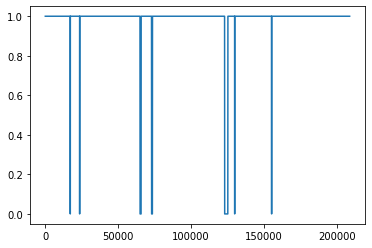

In [2]:
df_proc = pd.read_csv("../data/pump_sensors_processed.csv")
plt.plot(df_proc.machine_status)

In [3]:
df_proc['machine_status'] = df_proc.machine_status.astype(int)

In [4]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

def normalize_df(df_train, df_test):
    """
    Function to normalize the data using minimax scaler
    """
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(df_train.values)
    scaled_test = scaler.transform(df_test.values)
    train = pd.DataFrame(data=scaled_train, 
                         columns=df_train.columns, 
                         index=df_train.index)
    test = pd.DataFrame(data=scaled_test, 
                        columns=df_test.columns, 
                        index=df_test.index)
    return train, test

# train test split
train_dataPoints = 130000 
train = df_proc[:train_dataPoints]
test = df_proc[train_dataPoints:]

train_x = train.drop(["machine_status"], axis=1)
test_x = test.drop(["machine_status"], axis=1)
train_y = train[["machine_status"]]
test_y = test[["machine_status"]]

train_x, test_x = normalize_df(train_x, test_x)

#Train
n_estimators = int(sys.argv[4]) if len(sys.argv) > 4 else 10
max_depth = int(sys.argv[5]) if len(sys.argv) > 4 else 25

# declate rf and fit
rf = RandomForestClassifier(n_estimators=n_estimators, 
                            max_depth=max_depth,
                            criterion='gini', 
                            random_state=21, 
                            n_jobs=-1)
rf.fit(train_x, train_y)

# predict
pred = rf.predict(test_x)

f1_score(test_y, pred, average='macro')

/tmp/ipykernel_197/2994068266.py:42: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_x, train_y)


0.9106189762125637

In [5]:
test_y.value_counts()

machine_status
1                 78699
0                    76
dtype: int64

#### Variable Importance Plot

In [7]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(train_x)

In [8]:
train_x.mean()

sensor_00    0.914866
sensor_02    0.792563
sensor_04    0.761972
sensor_06    0.617684
sensor_07    0.670278
sensor_08    0.621903
sensor_09    0.593429
sensor_10    0.554923
sensor_11    0.675883
sensor_51    0.368020
dtype: float64

In [148]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], features=train_x.iloc[0,:])

In [151]:
explainer.expected_value

array([0.02806538, 0.97193462])

In [150]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values.values[0], features=train_x.iloc[0,:])

AttributeError: 'list' object has no attribute 'values'

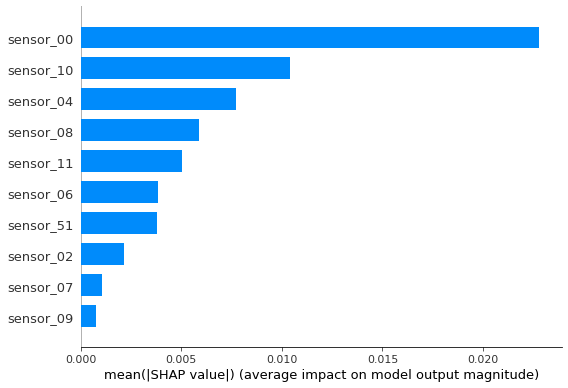

In [152]:
shap.summary_plot(shap_values[0], features=train_x, plot_type="bar")

quindi, valori bassi del sensore_00, hanno un impatto molto forte nel prevedere la classe Broken, cosi come s_10, s_04. Invece valori alti del sensore s_02, influiscono fortemente nella predizione della classe Broken (0)

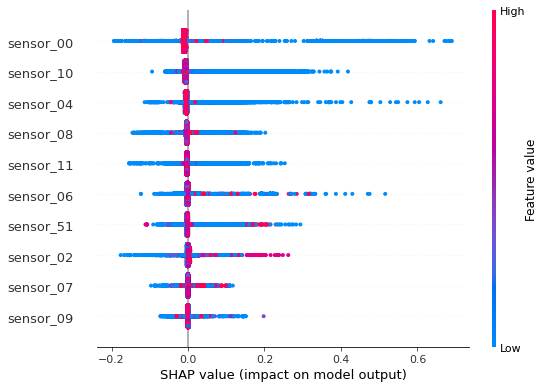

In [153]:
shap.summary_plot(shap_values[0], features=train_x)

In [ ]:
#shap.summary_plot(shap_values[1], features=train_x)

#### SHAP Dependence Plot — Global Interpretability

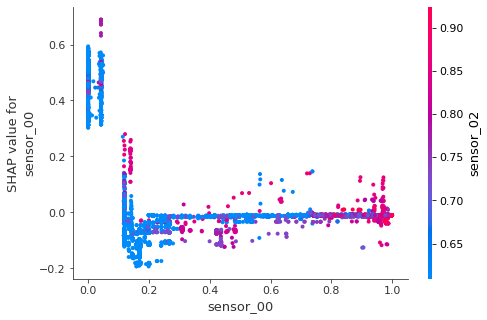

In [154]:
shap.dependence_plot("sensor_00", shap_values[0], train_x)

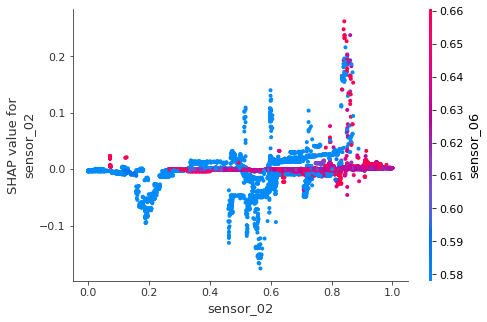

In [156]:
shap.dependence_plot("sensor_02", shap_values[0], train_x)

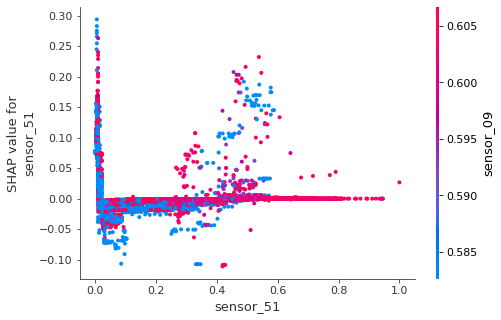

In [157]:
shap.dependence_plot("sensor_51", shap_values[0], train_x)

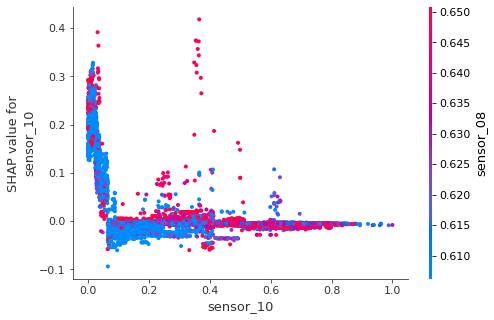

In [155]:
shap.dependence_plot("sensor_10", shap_values[0], train_x)

#### Individual SHAP Value Plot — Local Interpretability

In [10]:
x_out = test_x.copy()
x_out.loc[:,'predict'] = np.round(rf.predict(x_out),2)#
pred_sample = x_out.sample(10)
pred_sample

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51,predict
157628,0.980702,0.773437,0.794275,0.682572,0.727774,0.683224,0.665123,0.614262,0.835319,0.234478,1
156856,0.979159,0.802734,0.785273,0.658883,0.705702,0.666270,0.626628,0.564890,0.873212,0.331572,1
204120,0.952142,0.802734,0.770174,0.698139,0.703863,0.640988,0.604631,0.548637,0.821536,0.472259,1
148470,0.984176,0.822265,0.799501,0.674450,0.707848,0.666270,0.631259,0.646423,0.971932,0.592470,1
199593,0.963335,0.849609,0.789338,0.687648,0.703863,0.642474,0.606368,0.566483,0.921053,0.481506,1
160999,0.983790,0.757812,0.786435,0.677834,0.746781,0.702558,0.667149,0.525367,0.815211,0.272127,1
179951,0.961019,0.835937,0.785564,0.708291,0.709994,0.656454,0.615340,0.609459,0.851931,0.526420,1
172315,0.962563,0.826172,0.795146,0.705245,0.703863,0.647234,0.603184,0.595352,0.790180,0.361955,1
203813,0.984948,0.806640,0.781934,0.706599,0.711527,0.644259,0.602026,0.572593,0.755245,0.445178,1
132825,0.982246,0.742187,0.787596,0.669374,0.671980,0.629387,0.603184,0.621762,0.753948,0.416116,1


In [11]:
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(pred_sample)
    p = shap.force_plot(explainerModel.expected_value[0], shap_values_Model[0][j], pred_sample.iloc[[j]])
    return(p)

In [15]:
shap_plot(1)

In [13]:
pred_sample.mean()

sensor_00    0.973408
sensor_02    0.801953
sensor_04    0.787524
sensor_06    0.686903
sensor_07    0.709320
sensor_08    0.657912
sensor_09    0.622489
sensor_10    0.586523
sensor_11    0.838957
sensor_51    0.413408
predict      1.000000
dtype: float64